# hw3: Обучение без учителя

*выполнил Баулкин Данир М8О-312Б-23*


**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [35]:
X_train = np.loadtxt("X_train.txt")
y_train = np.loadtxt("y_train.txt", dtype=int)
subject_train = np.loadtxt("subject_train.txt", dtype=int)

X_test = np.loadtxt("X_test.txt")
y_test = np.loadtxt("y_test.txt", dtype=int)
subject_test = np.loadtxt("subject_test.txt", dtype=int)


In [34]:
# Проверим размерности
assert (X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert (X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [36]:
# Ваш код здесь
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate([y_train, y_test], axis=0)

Определим число уникальных значений меток целевого класса.

In [6]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [37]:
n_classes = np.unique(y).size
n_classes

6

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Mean:", np.round(X_scaled.mean(axis=0)[:5], 3), "…")
print("Std:", np.round(X_scaled.std(axis=0)[:5], 3), "…")

Mean: [ 0. -0. -0. -0.  0.] …
Std: [1. 1. 1. 1. 1.] …


Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

print("Variance:", pca.explained_variance_ratio_.sum())

Variance: 0.9004833346822929


**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- **65** !!!
- 66
- 193

In [38]:
print("кол-во:", pca.n_components_)

кол-во: 65


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- **51** !!!
- 56
- 61

In [39]:
variance_ratio = pca.explained_variance_ratio_[0]

print(round(variance_ratio * 100))

51


Визуализируйте данные в проекции на первые две главные компоненты.

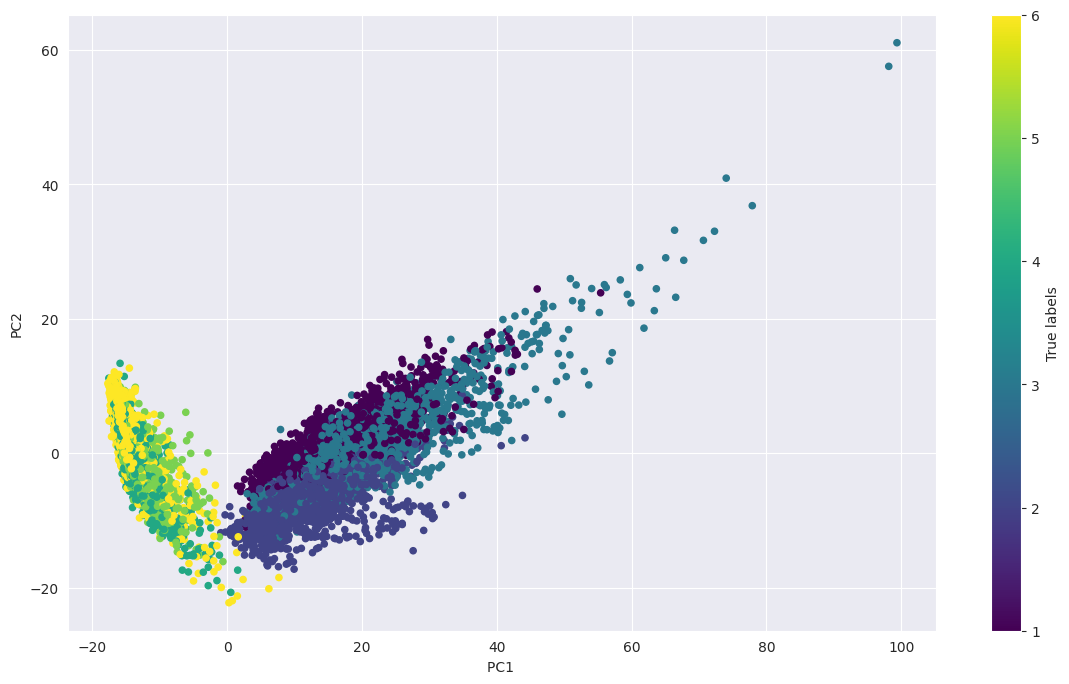

In [40]:
plt.figure(figsize=(14, 8))
plt.scatter(X_pca[:, 0],
            X_pca[:, 1],
            c=y,
            s=20,
            cmap='viridis')
plt.colorbar(label='True labels')
plt.xlabel('PC1 ')
plt.ylabel('PC2')
plt.show()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- **2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)** !!!
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [41]:
from sklearn.cluster import KMeans

number_clusters = n_classes
n_initialization = 100
fix_random_state = RANDOM_STATE

clustering_model = KMeans(
    n_clusters=number_clusters,
    random_state=fix_random_state,
    n_init=n_initialization
)

predicted_labels = clustering_model.fit_predict(X_pca)

cluster_centers_coordinates = clustering_model.cluster_centers_

print("Инерция -", clustering_model.inertia_)

Инерция - 2003454.625553257


In [43]:
import numpy as np

def kmeans_algorithm(data_matrix, num_clusters_val, n_initializations=10, max_iterations=500):
    min_overall_inertia = np.inf
    final_labels = None
    final_centroids = None

    for init_run_idx in range(n_initializations):
        initial_centroid_indices = np.random.choice(data_matrix.shape[0], num_clusters_val, replace=False)
        current_centroids = data_matrix[initial_centroid_indices].copy()

        for iter_count in range(max_iterations):
            distances_to_centroids = np.linalg.norm(data_matrix[:, np.newaxis] - current_centroids[np.newaxis, :], axis=2)
            assigned_labels = np.argmin(distances_to_centroids, axis=1)

            new_centroid_positions = np.array([
                data_matrix[assigned_labels == k_idx].mean(axis=0) if np.any(assigned_labels == k_idx) else current_centroids[k_idx]
                for k_idx in range(num_clusters_val)
            ])

            centroid_shift = np.linalg.norm(new_centroid_positions - current_centroids, axis=1).max()
            current_centroids = new_centroid_positions
            if centroid_shift < 1e-4:
                break

        current_inertia = sum(((data_matrix[assigned_labels == k_idx] - current_centroids[k_idx]) ** 2).sum() for k_idx in range(num_clusters_val))

        if current_inertia < min_overall_inertia:
            min_overall_inertia = current_inertia
            final_labels = assigned_labels.copy()
            final_centroids = current_centroids.copy()

    return final_labels, final_centroids, min_overall_inertia

cluster_labels, cluster_centers, model_inertia = kmeans_algorithm(
    X_pca,
    num_clusters_val=n_classes,
    n_initializations=100,
    max_iterations=500,
)

print("KMeans v3-", model_inertia)

KMeans v3- 2003454.7982992884


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

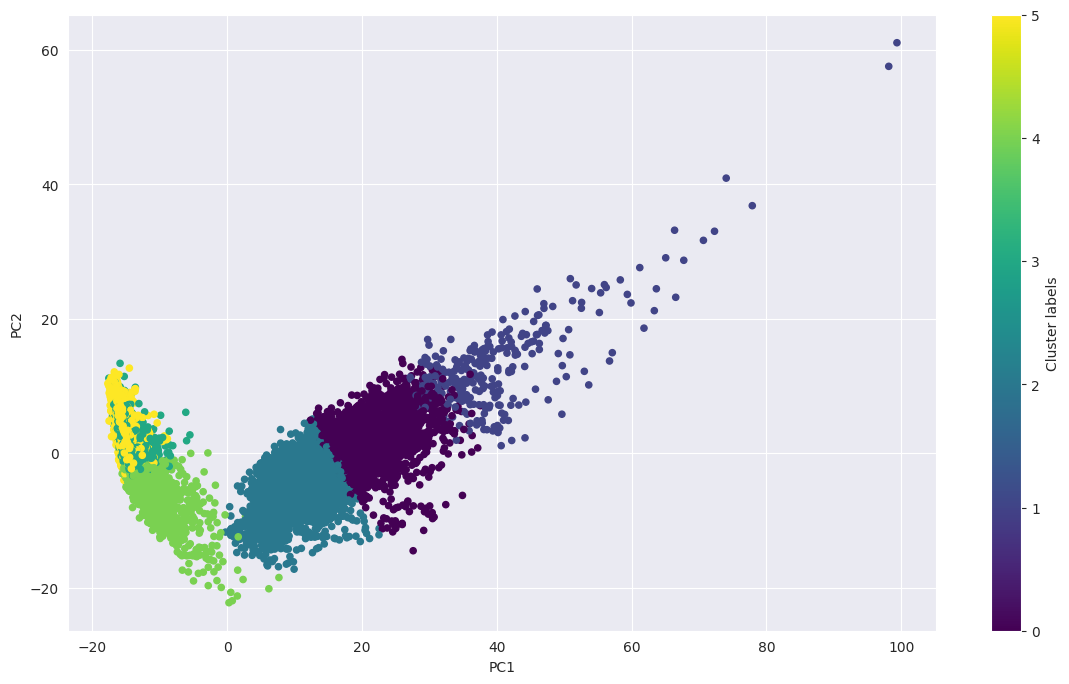

In [44]:
plt.figure(figsize=(14, 8))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=cluster_labels,
    s=20,
    cmap='viridis')
plt.colorbar(label='Cluster labels')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [16]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,741,0,0,78,903,1722
подъем вверх по лестнице,0,296,2,0,5,1241,1544
спуск по лестнице,0,890,0,0,196,320,1406
сидение,91,0,450,1235,0,1,1777
стояние,0,0,562,1344,0,0,1906
лежание,1558,0,329,52,0,5,1944
все,1649,1927,1343,2631,279,2470,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **перечисленные варианты не подходят** !!!

In [45]:
cluster_population_data = tab.iloc[:-1, :-1]

total_category_counts = tab['все'].iloc[:-1]

relative_proportions = cluster_population_data.divide(total_category_counts, axis='index')

max_proportion_each_category = relative_proportions.max(axis='columns')

top_separated_activity = max_proportion_each_category.idxmax()
top_separation_value = max_proportion_each_category.max()

print(f"Активность с наилучшей отделимостью: «{top_separated_activity}» с максимальной долей {top_separation_value:.2%}")

Активность с наилучшей отделимостью: «ходьба» с максимальной долей 99.60%


Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

100%|██████████| 6/6 [00:07<00:00,  1.17s/it]


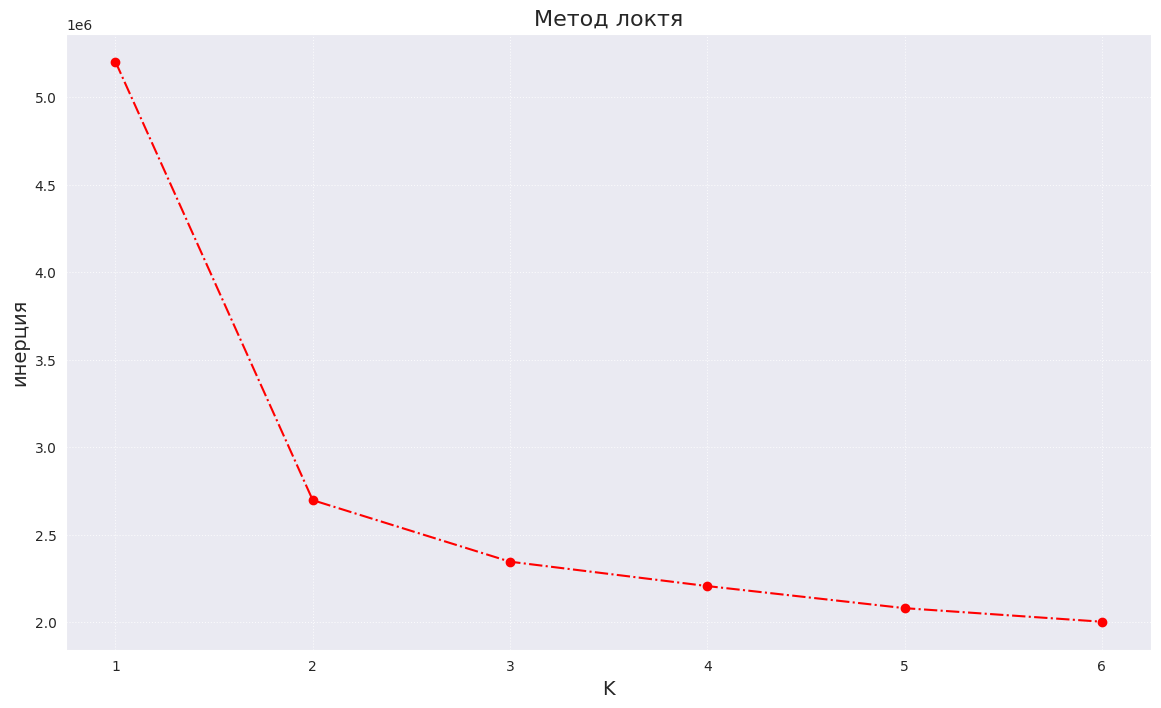

In [50]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm

inertia = []

possible_k_values = range(1, n_classes + 1)

for k in tqdm(possible_k_values):
    current_kmeans_model = KMeans(
        n_clusters=k,
        random_state=RANDOM_STATE,
        n_init=100
    )
    current_kmeans_model.fit(X_pca)
    inertia.append(current_kmeans_model.inertia_)

plt.figure(figsize=(14, 8))
plt.plot(possible_k_values, inertia, marker='o', linestyle='-.', color='red')
plt.xticks(possible_k_values)
plt.xlabel('K', fontsize=14)
plt.ylabel('инерция', fontsize=14)
plt.title('Метод локтя', fontsize=16)

plt.grid(True, linestyle=':', alpha=0.8)

plt.show()

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- **2**!!!
- 3
- 4

In [51]:
cluster_count = np.array(possible_k_values)
inertia_values = np.array(inertia)

start_point = np.array([cluster_count[0], inertia_values[0]])
end_point = np.array([cluster_count[-1], inertia_values[-1]])

vector = end_point - start_point

numerator_expression = np.abs(
    vector[1] * (cluster_count - start_point[0]) -
    vector[0] * (inertia_values - start_point[1]))


perpendicular_dist = numerator_expression / np.linalg.norm(vector)

k_optimal = cluster_count[np.argmax(perpendicular_dist)]

print(f"Предполагаемое оптимальное количество кластеров: {k_optimal}")

Предполагаемое оптимальное количество кластеров: 2


------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [20]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)
labels_ag = ag.labels_

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [52]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

optimal_kmeans_model = KMeans(
    n_clusters=n_classes,
    random_state=RANDOM_STATE,
    n_init=100
).fit(X_pca)

ari_agglomerative = adjusted_rand_score(y, labels_ag)
ari_kmeans = adjusted_rand_score(y, optimal_kmeans_model.labels_)

print(f"ARI для Агломеративной: {ari_agglomerative:.4f}")
print(f"ARI для K-Means:       {ari_kmeans:.4f}")

ARI для Агломеративной: 0.4936
ARI для K-Means:       0.4197


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering** !
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры** !!!
- **В случае случайного разбиения на кластеры ARI будет близок к нулю** !!!

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [ ]:
grid_search_optimizer = GridSearchCV(svc, svc_params, cv=3,n_jobs=-1)

grid_search_optimizer.fit(X_train_scaled, y_train)

best_svc = grid_search_optimizer.best_estimator_

highest_validation_score = grid_search_optimizer.best_score_

In [53]:
print(f"oптимальные параметры {grid_search_optimizer.best_params_}")

print(f"точность на train наборе: {grid_search_optimizer.best_score_:.4f}")

test_set_accuracy = best_svc.score(X_test_scaled, y_test)
print(f"точность на test наборе:        {test_set_accuracy:.4f}")

oптимальные параметры {'C': 0.1}
точность на train наборе: 0.9380
точность на test наборе:        0.9620


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1** !!!
- 1
- 10

In [26]:
y_predicted = best_svc.predict(X_test_scaled)

In [27]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- **по точности – сидение, по полноте – стояние** !

In [54]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

activity_labels_map = [
    'ходьба',
    'подъем вверх по лестнице',
    'спуск по лестнице',
    'сидение',
    'стояние',
    'лежание'
]

per_class_precision = precision_score(
    y_true=y_test,
    y_pred=y_predicted,
    labels=np.arange(1, 7),
    average=None
)

per_class_recall = recall_score(
    y_true=y_test,
    y_pred=y_predicted,
    labels=np.arange(1, 7),
    average=None
)

lowest_precision_index = np.argmin(per_class_precision)

lowest_recall_index = np.argmin(per_class_recall)

print(f"Активность с наименьшей точностью: {activity_labels_map[lowest_precision_index]}")
print(f"Активность с наименьшей полнотой:  {activity_labels_map[lowest_recall_index]}")

Активность с наименьшей точностью: стояние
Активность с наименьшей полнотой:  сидение


Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- **4%**!!!
- 10%
- 20%


In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
dimensionality_red = PCA(n_components=0.9, random_state=RANDOM_STATE)

ft_train_pca = dimensionality_red.fit_transform(X_train_scaled)
ft_test_pca = dimensionality_red.transform(X_test_scaled)
linear_svc_model = LinearSVC(random_state=RANDOM_STATE, max_iter=1000)
hyperpar_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid_search_processor = GridSearchCV(estimator=linear_svc_model, cv=3, param_grid=hyperpar_grid, n_jobs=-1
)

grid_search_processor.fit(ft_train_pca, y_train)
best_cv_score_aft_pca = grid_search_processor.best_score_
optimal_svc_pca_model = grid_search_processor.best_estimator_
performance_difference = round((highest_validation_score - best_cv_score_aft_pca) * 100)

print(f"оптимальное значение C- {grid_search_processor.best_params_['C']}")
print(f"точность CV- {grid_search_processor.best_score_:.6f}")
print(f"точность на тесте- {optimal_svc_pca_model.score(ft_test_pca, y_test):.6f}")
print(f"разница в качестве CV- {performance_difference}%")

оптимальное значение C: 0.1
точность CV: 0.898398
точность на тесте: 0.919240
разница в качестве CV: 4%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**!!!
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**!!!

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

eps- 43.2268


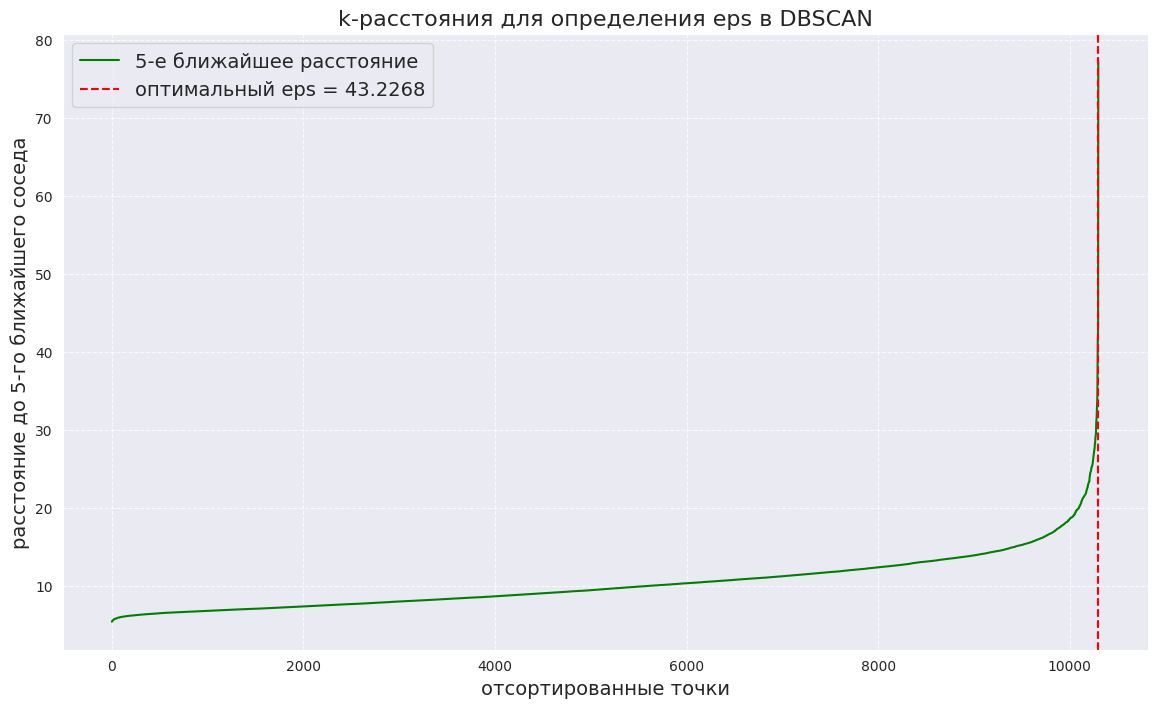

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

neighbor_finder = NearestNeighbors(n_neighbors=5)
neighbor_finder.fit(X_pca)

dist_to_neighbors, _ = neighbor_finder.kneighbors(X_pca)
sorted_k_dist = np.sort(dist_to_neighbors[:, 4])
first_der = np.gradient(sorted_k_dist)
second_der = np.gradient(first_der)
elbow_index = np.argmax(second_der)

chosen_eps = sorted_k_dist[elbow_index]
print(f"eps- {chosen_eps:.4f}")

plt.figure(figsize=(14, 8))
plt.plot(sorted_k_dist, label='5-е ближайшее расстояние', color='green')
plt.axvline(x=elbow_index, color='red', linestyle='--', label=f'оптимальный eps = {chosen_eps:.4f}')

plt.legend(fontsize=14)
plt.title('k-расстояния для определения еps в DBSCAN', fontsize=16)
plt.ylabel('расстояние до 5-го ближайшего соседа', fontsize=14)
plt.xlabel('отсортированные точки', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.8)
plt.show()

Распределение кластеров Counter({np.int64(0): 9661, np.int64(-1): 573, np.int64(1): 45, np.int64(5): 11, np.int64(4): 4, np.int64(3): 3, np.int64(2): 2})


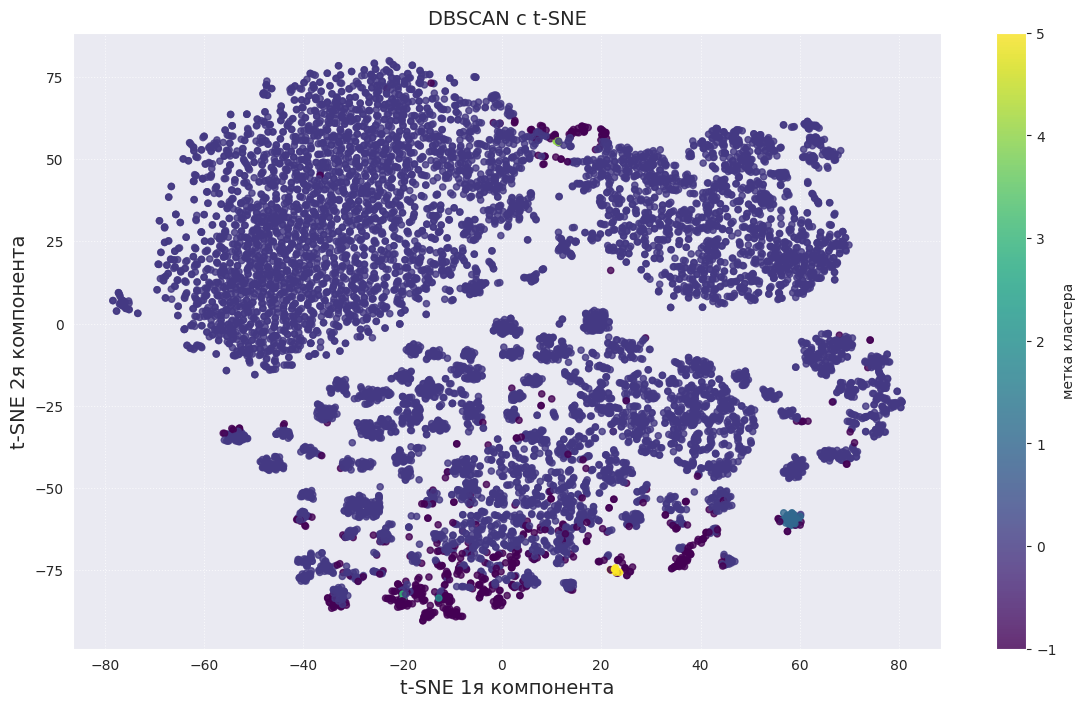

In [66]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from collections import Counter

epsilon_radius = 13
min_points_in_cluster = 5
density_based_clust = DBSCAN(eps=epsilon_radius, min_samples=min_points_in_cluster)
density_based_clust.fit(X_pca)

cluster_assignment_counts = Counter(density_based_clust.labels_)
print("Распределение кластеров", cluster_assignment_counts)

tsne_transform = TSNE(n_components=2, random_state=RANDOM_STATE, init='random')
transformed_data = tsne_transform.fit_transform(X_pca)

plt.figure(figsize=(14, 8))

plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=density_based_clust.labels_, cmap='viridis', s=20, alpha=0.8)

plt.colorbar(label='метка кластера')
plt.title(f'DBSCAN с t-SNE', fontsize=14)
plt.xlabel('t-SNE 1я компонента', fontsize=14)
plt.ylabel('t-SNE 2я компонента', fontsize=14)
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()